# Calculation of absorptivity/emissivity of a silicon heterojunction cell with pyramid textures
This example calculates the absorption (and thus emissivity) in all the individual layers of a silicon heterojunction (HIT) solar cell. [This paper](https://doi.org/10.1016/j.solmat.2019.110051) gives more details.

Start with relevant imports:

In [17]:
import numpy as np
import os

from solcore.structure import Layer
from solcore import material
from solcore.light_source import LightSource
from solcore.constants import q

from rayflare.textures import regular_pyramids
from rayflare.structure import Interface, BulkLayer, Structure
from rayflare.matrix_formalism import calculate_RAT
from rayflare.matrix_formalism import process_structure
from rayflare.options import default_options

import matplotlib.pyplot as plt
import seaborn as sns

from cycler import cycler

We then generate the wavelengths (equally spaced between 300 nm and 16 microns on a log scale) at which to calculate, and set some options. Note that for this example, we are using relatively few rays and angular bins so the example runs in a reasonable amount of time, but this means the results will have a lot of noise due to the stochastic nature of the ray-tracing. 

In [18]:
wavelengths = np.linspace(np.log(300), np.log(16*1000), 104)
wavelengths = np.round(np.floor(np.exp(wavelengths))*1e-9, 12)

options = default_options()
options.wavelengths = wavelengths
options.project_name = 'HIT_example'
options.n_rays = 5000
options.n_theta_bins = 20
options.nx = 5
options.ny = 5

Define the materials and the front and back material stacks. These are the layers which are deposited on the surface texture of the Si on each side. Note that these are custom materials (run the non-notebook version of this example in the examples folder to add them to your database).

In [19]:
Si = material('Si_UVtoMIR')()
Air = material('Air')()
ITO_front = material('ITO_front')()
ITO_back = material('ITO_back')()
Ag = material('Ag_Jiang')()
aSi_i = material('aSi_i')()
aSi_p = material('aSi_p')()
aSi_n = material('aSi_n')()


# stack based on doi:10.1038/s41563-018-0115-4
front_materials = [Layer(80e-9, ITO_front), Layer(6.5e-9, aSi_p), Layer(6.5e-9, aSi_i)]
back_materials = [Layer(6.5e-9, aSi_i), Layer(6.5e-9, aSi_p), Layer(240e-9, ITO_back)]

Define the surface textures for the front and back surface. These are pyramids in both cases, but because the pyramids are achieved using a chemical etch and are thus 'pointing out' of the surface in both cases. RayFlare defines 'upright' relative to the direction from which light is coming in, so the pyramids on the front surface are upright while those on the back surface are inverted (upright=False). The surface textures are used in combination with the layer stacks defined above to define the Interfaces of the cell, which are to be treated with the 'RT_TMM' method (ray-tracing + transfer-matrix method to correctly treat the surface layers). Then, finally, the bulk of the cell (Si) and thus the overall structure (front surface, bulk, back surface) is defined, also specifying the incidence medium above the cell (air) and the semi-infinite transmission medium behind the cell (silver).

In [20]:
surf = regular_pyramids(elevation_angle=55, upright=True)
surf_back = regular_pyramids(elevation_angle=55, upright=False)

front_surf = Interface('RT_TMM', texture=surf, layers=front_materials, name='HIT_front',
                       coherent=True)
back_surf = Interface('RT_TMM', texture=surf_back, layers=back_materials, name='HIT_back',
                      coherent=True)


bulk_Si = BulkLayer(170e-6, Si, name = 'Si_bulk') # bulk thickness in m

SC = Structure([front_surf, bulk_Si, back_surf], incidence=Air, transmission=Ag)

Now we are finished setting up, we run the calculation. process_structure calculates all the relevant matrices for the front and back surfaces (this can take a while). Then calculate_RAT does the matrix multiplication (this is fast). We then extract relevant results and use them to calculate the predicted photogenerated current in the cell.

In [21]:
process_structure(SC, options)

results = calculate_RAT(SC, options)

RAT = results[0]
results_per_pass = results[1]


R_per_pass = np.sum(results_per_pass['r'][0], 2)
R_0 = R_per_pass[0]
R_escape = np.sum(R_per_pass[1:, :], 0)

# only select absorbing layers, sum over passes
results_per_layer_front = np.sum(results_per_pass['a'][0], 0)

results_per_layer_back = np.sum(results_per_pass['a'][1], 0)


allres = np.flip(np.stack((results_per_layer_front[:,0], results_per_layer_front[:,1]+results_per_layer_front[:,2],
                            RAT['A_bulk'][0, :],
                    results_per_layer_back[:,0] + results_per_layer_back[:,1], results_per_layer_back[:,2], RAT['T'][0, :])), 0)

# calculated photogenerated current (Jsc with 100% EQE)

spectr_flux = LightSource(source_type='standard', version='AM1.5g', x=wavelengths,
                           output_units='photon_flux_per_m', concentration=1).spectrum(wavelengths)[1]

Jph_Si = q * np.trapz(RAT['A_bulk'][0] * spectr_flux, wavelengths)/10 # mA/cm2

Making lookuptable for element 0 in structure
Existing lookup table found
Making lookuptable for element 2 in structure
Existing lookup table found
Ray tracing with TMM lookup table for element 0 in structure
Existing angular redistribution matrices found
Existing angular redistribution matrices found
Ray tracing with TMM lookup table for element 2 in structure
Existing angular redistribution matrices found
After iteration 1 : maximum power fraction remaining = 0.6165996245936535
After iteration 2 : maximum power fraction remaining = 0.4150469191415954
After iteration 3 : maximum power fraction remaining = 0.2773729416174735
After iteration 4 : maximum power fraction remaining = 0.184837451289512
After iteration 5 : maximum power fraction remaining = 0.12454496119420891
After iteration 6 : maximum power fraction remaining = 0.08525054266044454
After iteration 7 : maximum power fraction remaining = 0.058350792198380935
After iteration 8 : maximum power fraction remaining = 0.03993723775

Finally, plot the results:

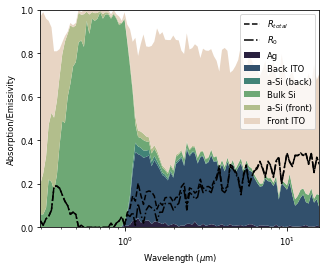

In [22]:
pal = sns.cubehelix_palette(allres.shape[0], start=.5, rot=-.9)
pal.reverse()
cols = cycler('color', pal)

params = {'legend.fontsize': 'small',
          'axes.labelsize': 'small',
          'axes.titlesize': 'small',
          'xtick.labelsize': 'small',
          'ytick.labelsize': 'small',
          'axes.prop_cycle': cols}

plt.rcParams.update(params)

# plot total R, A, T
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)
ax.semilogx(options['wavelengths']*1e6, R_escape + R_0, '--k', label=r'$R_{total}$')
ax.semilogx(options['wavelengths']*1e6, R_0, '-.k', label=r'$R_0$')
ax.stackplot(options['wavelengths']*1e6, allres, labels=['Ag', 'Back ITO', 'a-Si (back)', 'Bulk Si', 'a-Si (front)', 'Front ITO'])
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.set_ylabel('Absorption/Emissivity')
ax.set_xlim(min(options['wavelengths']*1e6), max(options['wavelengths']*1e6))
ax.set_ylim(0, 1)
plt.legend()
plt.show()